# NLTK.VADER_LEXICON

In [1]:
import pandas as pd

df = pd.read_csv("chatgpt_reddit - Complete.csv")
df.head(5)

,Post ID,Post author,Post title,Post URL,Post flair type,Post score,Post date,Comment ID,Comment author,Comment,Comment score,Comment date,Parent Comment ID,Parent comment author
0,13ucoev,TheHybred,If ChatGPT Can't Access The Internet Then How ...,https://www.reddit.com/r/ChatGPT/comments/13uc...,Jailbreak,4318,2023-05-29 00:10:45,jlzxh5p,AutoModerator,"Hey /u/TheHybred, please respond to this comme...",1,2023-05-29 00:10:45,13ucoev,TheHybred
1,13ucoev,TheHybred,If ChatGPT Can't Access The Internet Then How ...,https://www.reddit.com/r/ChatGPT/comments/13uc...,Jailbreak,4318,2023-05-29 00:10:45,jm090r5,sdmat,The reason for this is technical and surprisin...,2482,2023-05-29 01:42:37,13ucoev,TheHybred
2,13ucoev,TheHybred,If ChatGPT Can't Access The Internet Then How ...,https://www.reddit.com/r/ChatGPT/comments/13uc...,Jailbreak,4318,2023-05-29 00:10:45,jm0k235,bojodrop,Slide the jailbreak prompt,418,2023-05-29 03:13:53,13ucoev,TheHybred
3,13ucoev,TheHybred,If ChatGPT Can't Access The Internet Then How ...,https://www.reddit.com/r/ChatGPT/comments/13uc...,Jailbreak,4318,2023-05-29 00:10:45,jm0h4ut,opi098514,Easy. He was next in line. She’s old.,631,2023-05-29 02:49:38,13ucoev,TheHybred
4,13ucoev,TheHybred,If ChatGPT Can't Access The Internet Then How ...,https://www.reddit.com/r/ChatGPT/comments/13uc...,Jailbreak,4318,2023-05-29 00:10:45,jm0dl2p,Cryptizard,It could infer that you are trying to ask it a...,193,2023-05-29 02:20:05,13ucoev,TheHybred


## Preprocessing

### Detecting deleted comments (by moderators)

In [2]:
number_of_del_comments = len(df[df['Comment'] == '[deleted]'])
print(number_of_del_comments)

930


### Detecting deleted comments (by users)

In [3]:
number_of_rem_comments = len(df[df['Comment'] == '[removed]'])
print(number_of_rem_comments)

224


In [4]:
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import re

def clean_data(review):
    
    no_punc = re.sub(r'[^\w\s]', '', review)
    no_digits = ''.join([i for i in no_punc if not i.isdigit()])
    
    return(no_digits)

df['Post title'] = df['Post title'].apply(clean_data)
df['Comment'] = df['Comment'].apply(clean_data)

In [5]:
stop_words = set(stopwords.words('english'))  # Import english stop words
df['Comment'] = df['Comment'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word.lower() not in stop_words]))  # Remove stop words

## Sentiment analysis

In [6]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()


In [7]:
df['Sentiment'] = ''
for index, row in df.iterrows():
    comment = row['Comment']
    
    scores = sia.polarity_scores(comment)
    compound_score = scores['compound']
    
    if compound_score > 0:
        sentiment = 'pos'
    elif compound_score < 0:
        sentiment = 'neg'
    else:
        sentiment = 'neu'
    
    df.at[index, 'Sentiment'] = sentiment
    
df['Sentiment'].value_counts()

pos    32942
neu    18594
neg    16529
Name: Sentiment, dtype: int64

## Sentiment distribution

In [8]:
sizes = df["Sentiment"].value_counts()
sizes[1] += number_of_del_comments
sizes[2] += number_of_rem_comments
labels = df["Sentiment"].unique()

pos    32942
neu    19524
neg    16753
Name: Sentiment, dtype: int64

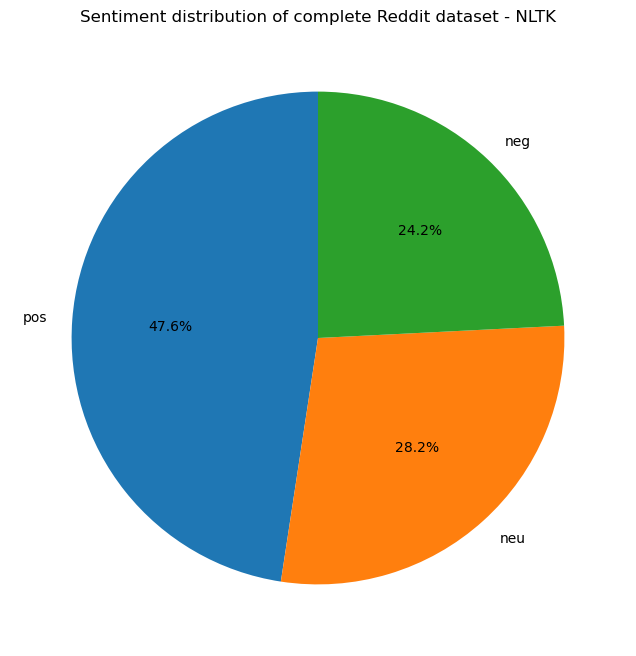

In [9]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [12, 8]

plt.pie(sizes, labels = labels, autopct = '%1.1f%%', shadow = False, startangle = 90)
plt.title("Sentiment distribution of complete Reddit dataset - NLTK")
plt.savefig("pie_nltksentiment-complete.png")
plt.show()

# Words, bigrams and trigrams distribution for positive comments

In [10]:
df_copy = df.copy()
df = df[df['Sentiment'] == 'pos']

## Words frequency

In [11]:
from nltk import FreqDist

tokens = []
for row in df['Comment']:
    tokens.extend(word_tokenize(str(row).lower()))  # Tokenization and lower conversion of the strings

word_freq = FreqDist(tokens)
sorted_freq = sorted(word_freq.items(), key = lambda x: x[1], reverse = True)

In [12]:
N = 50  # number of frequent words to print
for word, freq in sorted_freq[:N]:
    print(word, freq)

like 9204
ai 8982
chatgpt 7068
people 5405
would 5244
dont 4636
use 4411
im 4263
good 4154
think 4063
get 3573
one 3541
even 3380
work 3201
time 3180
make 3132
know 3047
gpt 3018
also 3011
could 2905
thats 2893
way 2841
well 2741
better 2659
using 2590
something 2550
write 2461
really 2453
things 2396
much 2309
want 2288
youre 2250
see 2244
need 2225
going 2143
writing 2042
used 2032
still 2011
say 1999
sure 1993
doesnt 1989
right 1949
actually 1941
human 1910
help 1777
cant 1774
ask 1750
thing 1704
data 1667
lot 1637


## Bigrams distribution

In [13]:
from nltk.tokenize import word_tokenize
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures

finder = BigramCollocationFinder.from_words(tokens)

In [14]:
bigram_freq = finder.ngram_fd
sorted_freq = sorted(bigram_freq.items(), key=lambda x: x[1], reverse=True)

In [15]:
N = 50
for ngram, freq in sorted_freq[:N]:
    print(ngram, freq)

('chat', 'gpt') 754
('dont', 'know') 544
('good', 'bot') 510
('dont', 'think') 494
('language', 'model') 456
('im', 'sure') 452
('bot', 'good') 438
('sounds', 'like') 424
('use', 'chatgpt') 385
('gon', 'na') 379
('seems', 'like') 370
('using', 'chatgpt') 345
('something', 'like') 323
('feel', 'like') 316
('use', 'ai') 308
('looks', 'like') 286
('make', 'sure') 267
('training', 'data') 266
('things', 'like') 263
('ai', 'language') 260
('using', 'ai') 252
('smart', 'robot') 252
('years', 'ago') 240
('writing', 'style') 239
('pretty', 'much') 233
('robot', 'response') 217
('response', 'automatic') 217
('ai', 'generated') 215
('dont', 'want') 205
('open', 'source') 201
('like', 'chatgpt') 200
('people', 'dont') 192
('automatic', 'thanks') 191
('much', 'better') 190
('dont', 'see') 188
('many', 'people') 186
('would', 'like') 184
('chatgpt', 'write') 184
('dont', 'understand') 180
('heres', 'think') 173
('dont', 'need') 170
('mental', 'health') 167
('look', 'like') 165
('dont', 'get') 162
(

## Trigrams distribution

In [16]:
finder = TrigramCollocationFinder.from_words(tokens)
trigram_freq = finder.ngram_fd
sorted_freq = sorted(trigram_freq.items(), key=lambda x: x[1], reverse=True)

In [17]:
N = 50
for ngram, freq in sorted_freq[:N]:
    print(ngram, freq)

('bot', 'good', 'bot') 435
('good', 'bot', 'good') 432
('ai', 'language', 'model') 222
('smart', 'robot', 'response') 217
('robot', 'response', 'automatic') 217
('response', 'automatic', 'thanks') 191
('bot', 'action', 'performed') 113
('action', 'performed', 'automatically') 113
('please', 'contact', 'moderators') 110
('heres', 'think', 'based') 110
('performed', 'automatically', 'please') 109
('automatically', 'please', 'contact') 109
('think', 'based', 'comments') 106
('im', 'pretty', 'sure') 77
('contact', 'moderators', 'subredditmessagecomposetorchatgpt') 76
('moderators', 'subredditmessagecomposetorchatgpt', 'questions') 76
('subredditmessagecomposetorchatgpt', 'questions', 'concerns') 76
('based', 'comments', 'seems') 74
('ai', 'image', 'generator') 72
('free', 'chatgpt', 'bot') 71
('chatgpt', 'bot', 'open') 71
('bot', 'open', 'assistant') 71
('open', 'assistant', 'bot') 71
('assistant', 'bot', 'opensource') 71
('bot', 'opensource', 'model') 71
('opensource', 'model', 'ai') 71
(

Main reasons we can deduce from the above list of trigraphs are: **good bot**, **smart robot response**, **it has a large language model**, **it's free and open (open source)**.

## Comments with highest score

In [18]:
df_temp = pd.read_csv("chatgpt_reddit - Complete.csv")
df_temp['Sentiment'] = df_copy['Sentiment']
df_complete = df_temp.copy()
df_neg = df_complete[df_complete['Sentiment'] == 'neg']
df_pos = df_complete[df_complete['Sentiment'] == 'pos']

In [19]:
ordered_df = df_pos.sort_values(by = 'Comment score', ascending = False)
ordered_df = ordered_df.head(10)
ordered_df

,Post ID,Post author,Post title,Post URL,Post flair type,Post score,Post date,Comment ID,Comment author,Comment,Comment score,Comment date,Parent Comment ID,Parent comment author,Sentiment
13266,13k2kgj,Sorin61,A Texas professor failed more than half of his...,https://www.reddit.com/r/technology/comments/1...,Society,41049,2023-05-17 15:58:58,jki6ch1,danielisbored,I don't remember the date username or any othe...,14409,2023-05-17 16:35:07,13k2kgj,Sorin61,pos
24448,13ao8i6,FunEntersTheChat,ChatGPT can pick stocks better than your fund ...,https://www.reddit.com/r/technology/comments/1...,Misleading,19246,2023-05-07 15:49:53,jj7mad3,Ahab_Ali,I believe that they had previous found that th...,11932,2023-05-07 16:09:03,13ao8i6,FunEntersTheChat,pos
26728,12ewvo1,esporx,The newest version of ChatGPT passed the US me...,https://www.reddit.com/r/technology/comments/1...,Artificial Intelligence,45138,2023-04-07 21:44:18,jfd2i9v,Little_Duckling,Not to nitpick… BUT the rarity of a condition ...,10140,2023-04-07 22:28:34,12ewvo1,esporx,pos
3490,13ty988,FunEntersTheChat,A lawyer used ChatGPT for legal filing. The ch...,https://www.reddit.com/r/technology/comments/1...,Artificial Intelligence,45616,2023-05-28 13:32:38,jlxlcbk,HanaBothWays,TFW you are trying new and interesting ways to...,8927,2023-05-28 13:41:17,13ty988,FunEntersTheChat,pos
4120,13ty988,FunEntersTheChat,A lawyer used ChatGPT for legal filing. The ch...,https://www.reddit.com/r/technology/comments/1...,Artificial Intelligence,45616,2023-05-28 13:32:38,jlxv2by,zuzg,">According to Schwartz, he was ""unaware of the...",8200,2023-05-28 15:17:15,jlxlcbk,HanaBothWays,pos
42580,13inwg2,SparkyBoomer23,ChatGPT Tried To Take Credit For My Work.,https://www.reddit.com/r/mildlyinfuriating/com...,NaN,23491,2023-05-16 01:13:58,jkasrt4,black_flag_4ever,Schools are going to go back to paper and penc...,6166,2023-05-16 01:30:12,13inwg2,SparkyBoomer23,pos
30196,13iexjz,shylow97,Is it unethical to have ChatGPT write a letter...,https://www.reddit.com/r/ChatGPT/comments/13ie...,Other,2442,2023-05-15 19:45:17,jk9p888,currentpattern,"Not unethical in the slightest, but I have som...",5820,2023-05-15 20:56:30,13iexjz,shylow97,pos
6582,128sm4x,deadprophetess,A guy on Tinder used ChatGPT on me,https://www.reddit.com/r/ChatGPT/comments/128s...,Funny,16243,2023-04-01 19:20:17,jekaw16,YasuouinKyouma,"This is already a SouthPark skit, guarantee yo...",5279,2023-04-01 20:01:56,128sm4x,deadprophetess,pos
53553,13ka7rg,markzuckerberg1234,I’ve been going back and forth with the lawyer...,https://www.reddit.com/r/ChatGPT/comments/13ka...,Educational Purpose Only,9027,2023-05-17 20:39:04,jkkbsf9,JackfruitJackelope,You’re talking with a lawyer whose client you’...,5007,2023-05-18 01:03:00,13ka7rg,markzuckerberg1234,pos
40552,12v1uu2,naturalbornfox,This is what ChatGPT considers the most notabl...,https://www.reddit.com/r/MapPorn/comments/12v1...,NaN,17641,2023-04-22 12:28:16,jh97zcw,PM_YOUR_BAKING_PICS,Austrians probably breathing a sigh of relief.,4998,2023-04-22 12:42:58,12v1uu2,naturalbornfox,pos


In [20]:
for index, row in ordered_df.iterrows():
    print(f"Comment: {row['Comment']}")

Comment: I don't remember the date username or any other such thing to link it, but there was a professor commenting on an article about the prevalence of AI generated papers and he said the tool he was provided to check for it had an unusually high positive rate, even for papers he seriously doubted were AI generated. As a test, he fed it several papers he had written in college and it tagged all of them as AI generated.

The gist is detection is way behind on this subject and relying on such things without follow-up is going to ruin a few peoples' lives.
Comment: I believe that they had previous found that throwing darts at a dartboard can pick stocks better than your fund manager.
Comment: Not to nitpick… BUT the rarity of a condition doesn’t necessarily affect how difficult it is to diagnose. Some rare conditions are quite unique and not difficult to recognize.
Comment: TFW you are trying new and interesting ways to get disbarred.
Comment: >According to Schwartz, he was "unaware of

# Words, bigrams and trigrams distribution for negative comments

### Detecting warnings from admin

In [21]:
df = df_copy
df = df[df['Sentiment'] == 'neg']

In [22]:
substring = 'httpswwwredditcom'
df_without_substr = df[~df['Comment'].str.contains(substring)]
df_without_substr

,Post ID,Post author,Post title,Post URL,Post flair type,Post score,Post date,Comment ID,Comment author,Comment,Comment score,Comment date,Parent Comment ID,Parent comment author,Sentiment
4,13ucoev,TheHybred,If ChatGPT Cant Access The Internet Then How I...,https://www.reddit.com/r/ChatGPT/comments/13uc...,Jailbreak,4318,2023-05-29 00:10:45,jm0dl2p,Cryptizard,could infer trying ask question would give dif...,193,2023-05-29 02:20:05,13ucoev,TheHybred,neg
5,13ucoev,TheHybred,If ChatGPT Cant Access The Internet Then How I...,https://www.reddit.com/r/ChatGPT/comments/13uc...,Jailbreak,4318,2023-05-29 00:10:45,jm0pebs,manikfox,link conversation directly feature see prompts...,77,2023-05-29 03:59:01,13ucoev,TheHybred,neg
13,13ucoev,TheHybred,If ChatGPT Cant Access The Internet Then How I...,https://www.reddit.com/r/ChatGPT/comments/13uc...,Jailbreak,4318,2023-05-29 00:10:45,jm0mgq6,Smile_Space,Well next line ChatGPT guessed next line based...,14,2023-05-29 03:34:11,13ucoev,TheHybred,neg
19,13ucoev,TheHybred,If ChatGPT Cant Access The Internet Then How I...,https://www.reddit.com/r/ChatGPT/comments/13uc...,Jailbreak,4318,2023-05-29 00:10:45,jm2hxcw,Useful_Hovercraft169,Gpt figured old people die let catch breath,3,2023-05-29 15:41:48,13ucoev,TheHybred,neg
20,13ucoev,TheHybred,If ChatGPT Cant Access The Internet Then How I...,https://www.reddit.com/r/ChatGPT/comments/13uc...,Jailbreak,4318,2023-05-29 00:10:45,jm3fmiq,AberrantRambler,See find key word limited knowledge world even...,3,2023-05-29 19:37:51,13ucoev,TheHybred,neg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68014,13sh7tw,rckatz2007,OpenAIs ChatGPT app tops K downloads in just ...,https://www.reddit.com/r/ChatGPT/comments/13sh...,News 📰,1317,2023-05-26 18:06:08,jlqng5b,jdmsi,Ah shit,10,2023-05-26 22:06:50,jlq64nj,RecycledAir,neg
68020,13sh7tw,rckatz2007,OpenAIs ChatGPT app tops K downloads in just ...,https://www.reddit.com/r/ChatGPT/comments/13sh...,News 📰,1317,2023-05-26 18:06:08,jlrdqc8,BathroomWest194,yea fix openai outspoken happened fix people s...,7,2023-05-27 01:23:38,jlq3789,hdbo16,neg
68025,13sh7tw,rckatz2007,OpenAIs ChatGPT app tops K downloads in just ...,https://www.reddit.com/r/ChatGPT/comments/13sh...,News 📰,1317,2023-05-26 18:06:08,jlvs9cr,surely_not_erik,wouldnt feel right Google Pixel Ill wait,2,2023-05-28 01:49:29,jlugttz,eyeswulf,neg
68028,13sh7tw,rckatz2007,OpenAIs ChatGPT app tops K downloads in just ...,https://www.reddit.com/r/ChatGPT/comments/13sh...,News 📰,1317,2023-05-26 18:06:08,jlqrrx6,punishingwind,NZ Australia WTF,13,2023-05-26 22:38:22,jlqr25a,AlienApricot,neg


## Words frequency

In [23]:
from nltk import FreqDist

tokens = []
for row in df_without_substr['Comment']:
    tokens.extend(word_tokenize(str(row).lower()))  # Tokenization and lower conversion of the strings

word_freq = FreqDist(tokens)
sorted_freq = sorted(word_freq.items(), key = lambda x: x[1], reverse = True)

In [24]:
N = 50  # number of frequent words to print
for word, freq in sorted_freq[:N]:
    print(word, freq) # Bigrams distribution

ai 3658
people 2871
chatgpt 2693
dont 2363
like 2217
would 1965
get 1761
im 1740
think 1579
one 1567
even 1545
use 1540
time 1366
know 1359
make 1319
thats 1259
work 1200
youre 1164
using 1146
could 1121
also 1069
doesnt 1064
way 1049
something 1039
shit 1036
going 1030
cant 1024
gpt 1023
really 1002
wrong 978
write 955
need 904
want 896
right 874
bad 871
say 850
see 837
things 816
still 816
thing 805
used 800
actually 784
isnt 770
much 762
didnt 758
problem 756
good 712
students 709
us 704
writing 703


## Bigrams distribution

In [25]:
from nltk.tokenize import word_tokenize
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures

finder = BigramCollocationFinder.from_words(tokens)

In [26]:
bigram_freq = finder.ngram_fd
sorted_freq = sorted(bigram_freq.items(), key=lambda x: x[1], reverse=True)

In [27]:
N = 50
for ngram, freq in sorted_freq[:N]:
    print(ngram, freq) # Trigrams distribution

('chat', 'gpt') 340
('dont', 'know') 283
('gon', 'na') 223
('dont', 'think') 208
('using', 'ai') 170
('using', 'chatgpt') 156
('language', 'model') 154
('dont', 'want') 143
('use', 'chatgpt') 136
('use', 'ai') 134
('people', 'dont') 111
('dont', 'understand') 109
('ai', 'generated') 104
('im', 'sorry') 104
('years', 'ago') 95
('dont', 'get') 89
('many', 'people') 89
('sounds', 'like') 88
('critical', 'thinking') 87
('im', 'sure') 86
('im', 'saying') 85
('feel', 'like') 83
('dont', 'care') 81
('something', 'like') 81
('chatgpt', 'write') 79
('doesnt', 'mean') 75
('dont', 'need') 74
('lot', 'people') 73
('written', 'ai') 72
('ai', 'language') 71
('training', 'data') 69
('ive', 'seen') 68
('ai', 'detectors') 67
('dont', 'see') 67
('things', 'like') 65
('make', 'sure') 65
('mental', 'health') 65
('cant', 'even') 64
('high', 'school') 64
('ai', 'detection') 63
('people', 'think') 63
('dont', 'even') 63
('every', 'time') 62
('seems', 'like') 61
('used', 'chatgpt') 59
('first', 'place') 58
('

## Trigrams distribution

In [28]:
finder = TrigramCollocationFinder.from_words(tokens)
trigram_freq = finder.ngram_fd
sorted_freq = sorted(trigram_freq.items(), key=lambda x: x[1], reverse=True)

In [29]:
N = 50
for ngram, freq in sorted_freq[:N]:
    print(ngram, freq)

('ai', 'language', 'model') 65
('using', 'chat', 'gpt') 29
('im', 'gon', 'na') 27
('deny', 'deny', 'deny') 21
('das', 'kommt', 'mir') 21
('large', 'language', 'model') 20
('use', 'chat', 'gpt') 20
('didnt', 'use', 'ai') 19
('critical', 'thinking', 'skills') 19
('people', 'dont', 'know') 18
('im', 'sorry', 'loss') 18
('students', 'using', 'ai') 17
('doesnt', 'make', 'sense') 17
('gon', 'na', 'get') 17
('moo', 'moo', 'moo') 17
('kommt', 'mir', 'spanisch') 17
('mir', 'spanisch', 'vor') 17
('nature', 'medical', 'emergency') 15
('disagree', 'agree', 'disagree') 15
('ich', 'verstehe', 'nur') 15
('innocent', 'proven', 'guilty') 14
('chat', 'gpt', 'write') 14
('please', 'state', 'nature') 14
('state', 'nature', 'medical') 14
('disagree', 'strongly', 'disagree') 14
('people', 'using', 'chatgpt') 13
('people', 'dont', 'understand') 13
('dont', 'really', 'care') 13
('sorry', 'ai', 'language') 13
('responses', 'must', 'follow') 13
('im', 'sorry', 'ai') 13
('verstehe', 'nur', 'bahnhof') 13
('use', 

Main reasons we can deduce from the above list of trigraphs are: **it tends to apologize too much**, **students using ai**.

## Comments with highest score

In [30]:
ordered_df = df_neg.sort_values(by = 'Comment score', ascending = False)
ordered_df = ordered_df.head(10)
ordered_df

,Post ID,Post author,Post title,Post URL,Post flair type,Post score,Post date,Comment ID,Comment author,Comment,Comment score,Comment date,Parent Comment ID,Parent comment author,Sentiment
26729,12ewvo1,esporx,The newest version of ChatGPT passed the US me...,https://www.reddit.com/r/technology/comments/1...,Artificial Intelligence,45138,2023-04-07 21:44:18,jfcysrd,apistat,Can't wait for the future where doctor bot can...,21920,2023-04-07 22:02:45,12ewvo1,esporx,neg
506,13ds87o,King_In_The_East,Being accused for using ChatGPT in my assignme...,https://www.reddit.com/r/ChatGPT/comments/13ds...,Educational Purpose Only,11873,2023-05-10 16:24:17,jjm42vc,elusivehonor,People in here are giving really bad advice. \...,9648,2023-05-10 17:28:26,13ds87o,King_In_The_East,neg
50066,12ok8jw,FunEntersTheChat,"ChatGPT is now writing college essays, and hig...",https://www.reddit.com/r/technology/comments/1...,Society,23819,2023-04-16 20:36:52,jgisved,assface,> as an experiment I found a pair of Earth Sci...,9513,2023-04-16 21:59:04,12ok8jw,FunEntersTheChat,neg
13804,13k2kgj,Sorin61,A Texas professor failed more than half of his...,https://www.reddit.com/r/technology/comments/1...,Society,41049,2023-05-17 15:58:58,jki9s79,cartsucks,I appreciate the professor realizing something...,4956,2023-05-17 16:58:09,jki6ch1,danielisbored,neg
27427,12ewvo1,esporx,The newest version of ChatGPT passed the US me...,https://www.reddit.com/r/technology/comments/1...,Artificial Intelligence,45138,2023-04-07 21:44:18,jfd0slu,HarlanCulpepper,And they'll only need one drop of blood to dia...,4569,2023-04-07 22:16:36,jfcysrd,apistat,neg
11068,144lfc1,rich_awo,Turned ChatGPT into the ultimate bro,https://www.reddit.com/r/ChatGPT/comments/144l...,Funny,58065,2023-06-08 23:16:59,jngf57i,Paradox_Dolphin,Broseph Stalin has me dead hahahaha.,3554,2023-06-09 00:17:07,144lfc1,rich_awo,neg
13269,13k2kgj,Sorin61,A Texas professor failed more than half of his...,https://www.reddit.com/r/technology/comments/1...,Society,41049,2023-05-17 15:58:58,jki94hl,oboshoe,Teachers relying on technology to fail student...,3553,2023-05-17 16:53:50,13k2kgj,Sorin61,neg
62410,135k20i,WickedSensitiveCrew,Chegg drops more than 40% after saying ChatGPT...,https://www.reddit.com/r/stocks/comments/135k2...,Company News,4973,2023-05-02 14:39:55,jik1s5d,VancouverSky,"So basically, the new stock investment strateg...",3382,2023-05-02 14:48:55,135k20i,WickedSensitiveCrew,neg
50074,12ok8jw,FunEntersTheChat,"ChatGPT is now writing college essays, and hig...",https://www.reddit.com/r/technology/comments/1...,Society,23819,2023-04-16 20:36:52,jgikwkx,bamfalamfa,chatgpt is a tool. this is what happens when y...,3129,2023-04-16 21:04:28,12ok8jw,FunEntersTheChat,neg
39012,13rg1zy,marketrent,Sam Altman says OpenAI will leave the EU if th...,https://www.reddit.com/r/technology/comments/1...,Politics,8713,2023-05-25 14:09:43,jlk1omt,beef-o-lipso,"Don't need an AI to interpret ""rules for thee ...",2962,2023-05-25 14:35:21,13rg1zy,marketrent,neg


In [31]:
for index, row in ordered_df.iterrows():
    print(f"Comment: {row['Comment']}")

Comment: Can't wait for the future where doctor bot can almost instantly diagnose a rare and hard to detect condition so insurance bot can deny coverage for the treatment much more efficiently.
Comment: People in here are giving really bad advice. 

The teacher does not seem unreasonable. They are using a tool that they may or may not know is ineffective at detecting, but probably was told to use by the faculty. ChatGPT has created issues with traditional assignments, and some people are cheating. Universities are trying to adapt to this change — don’t panic. 

If you really didn’t use AI, do NOT come across as hostile right off the bat, as it will set red flags. Immediately going to the Dean is not going to help you — that is such bad advice I can’t even comprehend why someone would suggest that. The Professor is not trying to fail you; they are asking for an informal meeting to talk about the allegation. 

Explain to them that you did not use AI, and ask how you can prove it. Bring a

Main reasons we can deduce from the above list of trigraphs are: **fear that in countries with paid healthcare, insurance coverage bots are more efficient than humans at denying treatment**, **ChatGPT has created problems with traditional assignments and some people cheat**, **chatgpt is a tool. this is what happens when you tell kids that computers and robots will take their jobs away. you either let them use the tools that have been created to replace them, or punish them for using the tools that have been created to replace them**, **the new stock investment strategy for the next year or two, is find businesses that'll be killed by AI and short them**.

# TextBlob

In [32]:
import pandas as pd

df = pd.read_csv("chatgpt_reddit - Complete.csv")
df.head(5)

,Post ID,Post author,Post title,Post URL,Post flair type,Post score,Post date,Comment ID,Comment author,Comment,Comment score,Comment date,Parent Comment ID,Parent comment author
0,13ucoev,TheHybred,If ChatGPT Can't Access The Internet Then How ...,https://www.reddit.com/r/ChatGPT/comments/13uc...,Jailbreak,4318,2023-05-29 00:10:45,jlzxh5p,AutoModerator,"Hey /u/TheHybred, please respond to this comme...",1,2023-05-29 00:10:45,13ucoev,TheHybred
1,13ucoev,TheHybred,If ChatGPT Can't Access The Internet Then How ...,https://www.reddit.com/r/ChatGPT/comments/13uc...,Jailbreak,4318,2023-05-29 00:10:45,jm090r5,sdmat,The reason for this is technical and surprisin...,2482,2023-05-29 01:42:37,13ucoev,TheHybred
2,13ucoev,TheHybred,If ChatGPT Can't Access The Internet Then How ...,https://www.reddit.com/r/ChatGPT/comments/13uc...,Jailbreak,4318,2023-05-29 00:10:45,jm0k235,bojodrop,Slide the jailbreak prompt,418,2023-05-29 03:13:53,13ucoev,TheHybred
3,13ucoev,TheHybred,If ChatGPT Can't Access The Internet Then How ...,https://www.reddit.com/r/ChatGPT/comments/13uc...,Jailbreak,4318,2023-05-29 00:10:45,jm0h4ut,opi098514,Easy. He was next in line. She’s old.,631,2023-05-29 02:49:38,13ucoev,TheHybred
4,13ucoev,TheHybred,If ChatGPT Can't Access The Internet Then How ...,https://www.reddit.com/r/ChatGPT/comments/13uc...,Jailbreak,4318,2023-05-29 00:10:45,jm0dl2p,Cryptizard,It could infer that you are trying to ask it a...,193,2023-05-29 02:20:05,13ucoev,TheHybred


## Preprocessing

### Detecting deleted comments (by moderators)

In [33]:
number_of_del_comments = len(df[df['Comment'] == '[deleted]'])
print(number_of_del_comments)

930


### Detecting deleted comments (by users)

In [34]:
number_of_del_comments = len(df[df['Comment'] == '[removed]'])
print(number_of_del_comments)

224


In [35]:
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import re

def clean_data(review):
    
    no_punc = re.sub(r'[^\w\s]', '', review)
    no_digits = ''.join([i for i in no_punc if not i.isdigit()])
    
    return(no_digits)

df['Post title'] = df['Post title'].apply(clean_data)
df['Comment'] = df['Comment'].apply(clean_data)

In [36]:
stop_words = set(stopwords.words('english'))  # Import english stop words
df['Comment'] = df['Comment'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word.lower() not in stop_words]))  # Remove stop words

## Sentiment analysis

In [37]:
from textblob import TextBlob

df['Sentiment'] = ''

for index, row in df.iterrows():
    comment = row['Comment']
    
    blob = TextBlob(comment)
    sentiment = blob.sentiment.polarity
    
    if sentiment > 0:
        sentiment_label = 'pos'
    elif sentiment < 0:
        sentiment_label = 'neg'
    else:
        sentiment_label = 'neu'
    
    df.at[index, 'Sentiment'] = sentiment_label

df['Sentiment'].value_counts()

pos    31663
neu    22796
neg    13606
Name: Sentiment, dtype: int64

## Sentiment distribution

In [38]:
sizes = df["Sentiment"].value_counts()
sizes[1] += number_of_del_comments
sizes[2] += number_of_rem_comments
labels = df["Sentiment"].unique()

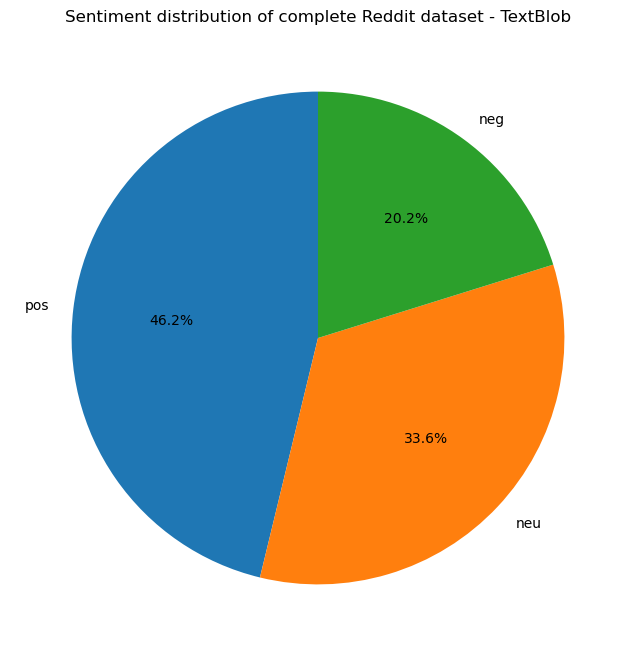

In [39]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [12, 8]

plt.pie(sizes, labels = labels, autopct = '%1.1f%%', shadow = False, startangle = 90)
plt.title("Sentiment distribution of complete Reddit dataset - TextBlob")
plt.savefig("pie_textblobsentiment-complete.png")
plt.show()